
<hr>

#*Pilotaje para la prueba de tamizaje para evaluación de lesiones dermatológicas como ayuda diagnostica a través de inteligencia artificial.*


**Cuál es el objetivo?**

Crear una herramienta en línea que pueda indicar a los médicos y técnicos de laboratorio los tres diagnósticos de mayor probabilidad para una determinada lesión de piel. Esto les ayudará a identificar rápidamente a los pacientes de alta prioridad y a acelerar su flujo de trabajo, luego reducir la probabilidad de desarrolar algun tipo de cancér que ponga en peligro al paciente. La aplicación debería producir un resultado en menos de 3 segundos. Para asegurar la privacidad, las imágenes deben ser pre-procesadas y analizadas localmente y nunca ser subidas a un servidor externo.

In [16]:
!/opt/bin/nvidia-smi
!nvcc --version

Tue Apr  2 15:35:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--


+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+

In [17]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)


import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


**LABELS**<br>

Excerpts from the paper:<br>
> The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions<br>
https://arxiv.org/abs/1803.10417



 **nv**<br>
 Los nevos melanocíticos son neoplasias benignas de los melanocitos y se presentan en una miríada de variantes, todas ellas incluidas en nuestra serie. Las variantes pueden diferir significativamente desde el punto de vista dermatoscópico.<br>
 *[6705 images]*

 **mel**<br>
 El melanoma es una neoplasia maligna derivada de los melanocitos que puede aparecer en diferentes variantes. Si se extirpa en una fase temprana, puede curarse mediante una simple escisión quirúrgica. Los melanomas pueden ser invasivos o no invasivos (in situ). Incluimos todas las variantes de melanoma, incluido el melanoma in situ, pero excluimos el melanoma no pigmentado, subungueal, ocular o de las mucosas.<br>*[1113 images]*


**bkl**<br>
 La "queratosis benigna" es una clase genérica que incluye la queratosis seborreica ("verruga senil"), el lentigo solar -que puede considerarse una variante plana de la queratosis seborreica- y la queratosis de tipo liquen plano (LPLK), que corresponde a una queratosis seborreica o a un lentigo solar con inflamación y regresión [22]. Los tres subgrupos pueden tener un aspecto dermatoscópico diferente, pero los hemos agrupado porque son similares desde el punto de vista biológico y a menudo se presentan bajo el mismo término genérico desde el punto de vista histopatológico. Desde el punto de vista dermatoscópico, las queratosis similares al liquen plano son especialmente difíciles porque pueden mostrar características morfológicas que imitan al melanoma [23] y a menudo se les practica una biopsia o una extirpación por motivos de diagnóstico. .<br>
*[1099 images]*

**bcc**<br>
El carcinoma basocelular es una variante común del cáncer de piel epitelial que rara vez hace metástasis, pero que crece destructivamente si no se trata. Aparece en diferentes variantes morfológicas (plano, nodular, pigmentado, quístico, etc.) [21], todas ellas incluidas en este conjunto.<br>
*[514 images]*

**akiec**<br>
Las queratosis actínicas (queratosis solares) y el carcinoma intraepitelial (enfermedad de Bowen) son variantes comunes no invasivas del carcinoma de células escamosas que pueden tratarse localmente sin cirugía. Algunos autores los consideran precursores de los carcinomas de células escamosas y no carci- nomas propiamente dichos. Sin embargo, hay acuerdo en que estas lesiones pueden evolucionar hacia un carcinoma de células escamosas invasivo, que normalmente no está pigmentado. Ambas neoplasias suelen mostrar escamas en la superficie y suelen carecer de pigmento. Las queratosis actínicas son más comunes en la cara y la enfermedad de Bowen es más común en otras zonas del cuerpo. Dado que ambos tipos son producidos por la luz ultravioleta, la piel circundante suele estar muy dañada por el sol, excepto en los casos de la enfermedad de Bowen, que están causados por la infección del virus del papiloma humano y no por la luz ultravioleta. Existen variantes pigmentadas para la enfermedad de Bowen [19] y para las queratosis actínicas [20]. Ambas se incluyen en este conjunto.<br>*[327 images]*


**vasc**<br>
Las lesiones vasculares de la piel en el conjunto de datos van desde los angiomas de cereza hasta los angioqueratomas [25] y los granulomas piogénicos [26]. Las hemorragias también se incluyen en esta categoría.<br>
*[142 images]*

**df**<br>
El dermatofibroma es una lesión cutánea benigna considerada como una proliferación benigna o una reacción inflamatoria a un traumatismo mínimo. Es de color marrón y a menudo muestra una zona central de fibrosis dermatoscópica [24].<br>*[115 images]*


<br>*[Total images = 10015]*

In [18]:
from google.colab import files
files.upload()  # Sube el archivo kaggle.json aquí

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!mkdir -p data  # Asegúrate de que la carpeta se crea solo si no existe previamente

# Aquí sustituye 'algún/dataset-id' con el identificador real del dataset que deseas descargar
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p data

Saving kaggle.json to kaggle (1).json
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
# Descomprime el archivo zipfile completo en /content/data
!unzip -o data/chest-xray-pneumonia.zip -d data

# Informa cuántos archivos se descomprimieron
!echo files in /content/data: `ls data | wc -l`


Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0447-0001.jpeg  

In [20]:
os.listdir('./data')

['chest_xray', 'train', 'chest-xray-pneumonia.zip', 'val']

### Crear la estructura de directorios

En estas carpetas almacenaremos las imágenes que posteriormente alimentarán los generadores de Keras.

In [21]:
import os

# Create a new directory
base_dir = 'base_dir'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Create directories for training and validation datasets
train_dir = os.path.join(base_dir, 'train_dir')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

# Categories
categories = ['PNEUMONIA', 'NORMAL']

# Create category folders in both training and validation directories
for category in categories:
    # Training directory for the category
    train_category_dir = os.path.join(train_dir, category)
    if not os.path.exists(train_category_dir):
        os.mkdir(train_category_dir)

    # Validation directory for the category
    val_category_dir = os.path.join(val_dir, category)
    if not os.path.exists(val_category_dir):
        os.mkdir(val_category_dir)

### Crear conjuntos de entrenamiento y val

In [22]:
import os
import pandas as pd

# Ruta base donde están almacenadas las imágenes
base_dir = 'data/chest_xray'

# Categorías (podrían ser 'train', 'test', 'val')
categories = ['train', 'test', 'val']

# Clases de imágenes
classes = ['NORMAL', 'PNEUMONIA']

# Lista para almacenar los registros
data = []

# Recorre las categorías y las clases para recopilar nombres de archivos y etiquetas
for category in categories:
    for image_class in classes:
        # Construye la ruta al directorio específico
        dir_path = os.path.join(base_dir, category, image_class)
        # Lista todos los archivos en el directorio
        files = os.listdir(dir_path)

        # Añade un registro por archivo al listado
        for file in files:
            data.append({
                'Category': category,
                'Class': image_class,
                'Filepath': os.path.join(dir_path, file)
            })

# Crea un DataFrame con los datos recopilados
df_data = pd.DataFrame(data)

df_data.head()


,Category,Class,Filepath
0,train,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-1335-0...
1,train,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-1343-0...
2,train,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-1047-0...
3,train,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-0808-0...
4,train,NORMAL,data/chest_xray/train/NORMAL/IM-0164-0001.jpeg


### Crear un conjunto de val estratificado

In [23]:
from sklearn.model_selection import train_test_split

# Suponiendo que 'Class' es tu columna objetivo y 'Filepath' es la columna que contiene las rutas a las imágenes
X = df_data['Filepath']  # Las rutas a las imágenes
y = df_data['Class']  # La clase de cada imagen

# Dividir los datos en conjuntos de entrenamiento y validación, manteniendo la proporción de clases en ambos conjuntos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear DataFrame para el conjunto de entrenamiento
train_df = pd.DataFrame({'Filepath': X_train, 'Class': y_train})

# Crear DataFrame para el conjunto de validación
val_df = pd.DataFrame({'Filepath': X_val, 'Class': y_val})

# Muestra los primeros registros del conjunto de entrenamiento para verificar
train_df.head()


,Filepath,Class
5786,data/chest_xray/test/PNEUMONIA/person100_bacte...,PNEUMONIA
1427,data/chest_xray/train/PNEUMONIA/person1597_bac...,PNEUMONIA
4746,data/chest_xray/train/PNEUMONIA/person536_bact...,PNEUMONIA
3695,data/chest_xray/train/PNEUMONIA/person423_bact...,PNEUMONIA
1987,data/chest_xray/train/PNEUMONIA/person1366_vir...,PNEUMONIA


In [24]:
def identify_category(x):
    if x.startswith('NORMAL'):
        return 'NORMAL'
    else:
        return 'PNEUMONIA'

# Asumiendo que tu DataFrame df_data tiene una columna 'Filepath' que incluye el nombre de la imagen
# que usualmente contiene la palabra 'NORMAL' o 'PNEUMONIA' en su ruta
df_data['Category'] = df_data['Filepath'].apply(lambda x: 'NORMAL' if 'NORMAL' in x else 'PNEUMONIA')
df_data.head()


,Category,Class,Filepath
0,NORMAL,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-1335-0...
1,NORMAL,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-1343-0...
2,NORMAL,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-1047-0...
3,NORMAL,NORMAL,data/chest_xray/train/NORMAL/NORMAL2-IM-0808-0...
4,NORMAL,NORMAL,data/chest_xray/train/NORMAL/IM-0164-0001.jpeg


In [27]:
# Contando valores en la columna 'Category'
category_counts = df_data['Category'].value_counts()

print(category_counts)


PNEUMONIA    4273
NORMAL       1583
Name: Category, dtype: int64


In [26]:
# now we filter out images that don't have duplicates
#df = df_data[df_data['duplicates'] == 'no_duplicates']

#df.shape

In [28]:
from sklearn.model_selection import train_test_split

# 'Category' es equivalente a 'dx' en tu dataset, indicando la clase de la imagen
y = df_data['Category']

# Realizamos la división, estratificando por 'y' para mantener la proporción de clases
_, df_val = train_test_split(df_data, test_size=0.17, random_state=101, stratify=y)

print(df_val.shape)


(996, 3)


In [29]:
df_val['Category'].value_counts()

PNEUMONIA    727
NORMAL       269
Name: Category, dtype: int64

### Crear un conjunto de entrenamiento  que excluya las imágenes que están en el conjunto val

In [30]:
# Primero, asegúrate de que df_data tenga un índice único si aún no lo tiene
df_data.reset_index(drop=True, inplace=True)

# Creamos un conjunto (set) de índices de validación para una búsqueda rápida
val_indices = set(df_val.index)

# Esta función marca cada fila como 'val' o 'train' basándose en su índice
def identify_val_rows(index):
    return 'val' if index in val_indices else 'train'

# Aplicamos la función a lo largo del índice de df_data para crear la nueva columna 'train_or_val'
df_data['train_or_val'] = df_data.index.map(identify_val_rows)

# Filtramos las filas de entrenamiento
df_train = df_data[df_data['train_or_val'] == 'train']

# Mostramos la cantidad de filas en cada conjunto para verificar
print(f"Entrenamiento: {len(df_train)}")
print(f"Validación: {len(df_val)}")


Entrenamiento: 4860
Validación: 996


In [31]:
df_train['Category'].value_counts()

PNEUMONIA    3546
NORMAL       1314
Name: Category, dtype: int64

In [32]:
df_val['Category'].value_counts()

PNEUMONIA    727
NORMAL       269
Name: Category, dtype: int64

### Transferencia de las imágenes a las carpetas

In [33]:
# Establece 'Filepath' como el índice en df_data
df_data.set_index('Filepath', inplace=True)

In [34]:
import os
import shutil

# Asumiendo que df_train y df_val ya tienen un índice basado en 'Filepath'
# y que cada uno tiene una columna 'Category' para las etiquetas

# Define los directorios de destino para las imágenes de entrenamiento y validación
train_dir = './data/train'
val_dir = './data/val'

# Crea los directorios de destino si no existen
for category in ['NORMAL', 'PNEUMONIA']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

def transfer_images(df, destination_dir):
    for _, row in df.iterrows():
        # Obtiene la ruta del archivo de la columna adecuada
        filepath = row['Filepath']
        # Obtiene la etiqueta de la categoría de la imagen
        label = row['Category']
        # Define la ruta de destino basada en la etiqueta
        dst = os.path.join(destination_dir, label, os.path.basename(filepath))
        # Copia la imagen al destino
        shutil.copyfile(filepath, dst)

# Asegúrate de que df_train y df_val tengan una columna 'Filepath' que contenga las rutas de las imágenes
# Si 'Filepath' es actualmente el índice, primero restablece el índice:
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)

# Luego, continúa con la transferencia de imágenes
transfer_images(df_train, train_dir)
transfer_images(df_val, val_dir)


In [36]:
import os

# Reemplaza 'base_dir2/train_dir' con la ruta correcta a tu directorio de entrenamiento
train_dir_normal = os.path.join(train_dir, 'NORMAL')
train_dir_pneumonia = os.path.join(train_dir, 'PNEUMONIA')

# Cuenta y muestra la cantidad de imágenes en cada categoría del conjunto de entrenamiento
print("Número de imágenes de entrenamiento clasificadas como NORMAL:", len(os.listdir(train_dir_normal)))
print("Número de imágenes de entrenamiento clasificadas como PNEUMONIA:", len(os.listdir(train_dir_pneumonia)))


Número de imágenes de entrenamiento clasificadas como NORMAL: 1314
Número de imágenes de entrenamiento clasificadas como PNEUMONIA: 3546


In [37]:
import os

# Asegúrate de reemplazar 'val_dir' con la ruta correcta a tu directorio de validación si no está definido
val_dir_normal = os.path.join(val_dir, 'NORMAL')
val_dir_pneumonia = os.path.join(val_dir, 'PNEUMONIA')

# Cuenta y muestra la cantidad de imágenes en cada categoría del conjunto de validación
print("Número de imágenes de validación clasificadas como NORMAL:", len(os.listdir(val_dir_normal)))
print("Número de imágenes de validación clasificadas como PNEUMONIA:", len(os.listdir(val_dir_pneumonia)))


Número de imágenes de validación clasificadas como NORMAL: 269
Número de imágenes de validación clasificadas como PNEUMONIA: 727


### Copiar las imágenes del tren en aug_dir

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import numpy as np

# Asegúrate de que esta sea la ruta correcta a tu directorio de imágenes de entrenamiento
base_dir = 'data/train'  # Ejemplo de ruta, ajusta según sea necesario

class_list = ['PNEUMONIA']

for item in class_list:
    aug_dir = os.path.join(base_dir, 'aug_dir')
    os.makedirs(aug_dir, exist_ok=True)

    img_dir = os.path.join(aug_dir, 'img_dir')
    os.makedirs(img_dir, exist_ok=True)

    img_class = item

    # Asegúrate de que esta ruta exista y sea correcta
    img_list = os.listdir(os.path.join(base_dir, img_class))

    for fname in img_list:
        src = os.path.join(base_dir, img_class, fname)
        dst = os.path.join(img_dir, fname)
        shutil.copyfile(src, dst)

    # Configura el generador de aumento de imágenes
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 10

    aug_datagen = datagen.flow_from_directory(
        aug_dir,
        save_to_dir=os.path.join(base_dir, img_class),
        save_format='jpg',
        target_size=(224,224),
        batch_size=batch_size)

    num_aug_images_wanted = 1000  # Ajusta este número según la necesidad
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # Limpia al finalizar
    shutil.rmtree(aug_dir)




Found 3546 images belonging to 1 classes.


In [39]:
# Definimos la ruta base a tu directorio de entrenamiento ajustado
# Asegúrate de ajustar esta ruta a tu estructura de directorios actual
train_dir_normal = 'data/train/NORMAL'
train_dir_pneumonia = 'data/train/PNEUMONIA'

# Imprime la cantidad de imágenes en cada categoría de entrenamiento
# Esto incluye las imágenes originales más las imágenes aumentadas
print("Número de imágenes de entrenamiento clasificadas como NORMAL:", len(os.listdir(train_dir_normal)))
print("Número de imágenes de entrenamiento clasificadas como PNEUMONIA:", len(os.listdir(train_dir_pneumonia)))


Número de imágenes de entrenamiento clasificadas como NORMAL: 1314
Número de imágenes de entrenamiento clasificadas como PNEUMONIA: 3546


In [40]:
# Asumiendo que 'val_dir' es tu directorio de validación ajustado
# Asegúrate de ajustar esta ruta a tu estructura de directorios actual
val_dir_normal = 'data/val/NORMAL'
val_dir_pneumonia = 'data/val/PNEUMONIA'

# Imprime la cantidad de imágenes en cada categoría de validación
print("Número de imágenes de validación clasificadas como NORMAL:", len(os.listdir(val_dir_normal)))
print("Número de imágenes de validación clasificadas como PNEUMONIA:", len(os.listdir(val_dir_pneumonia)))


Número de imágenes de validación clasificadas como NORMAL: 269
Número de imágenes de validación clasificadas como PNEUMONIA: 727


### Visualizar 50 imágenes aumentadas

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image # Asegúrate de tener keras o tensorflow instalado


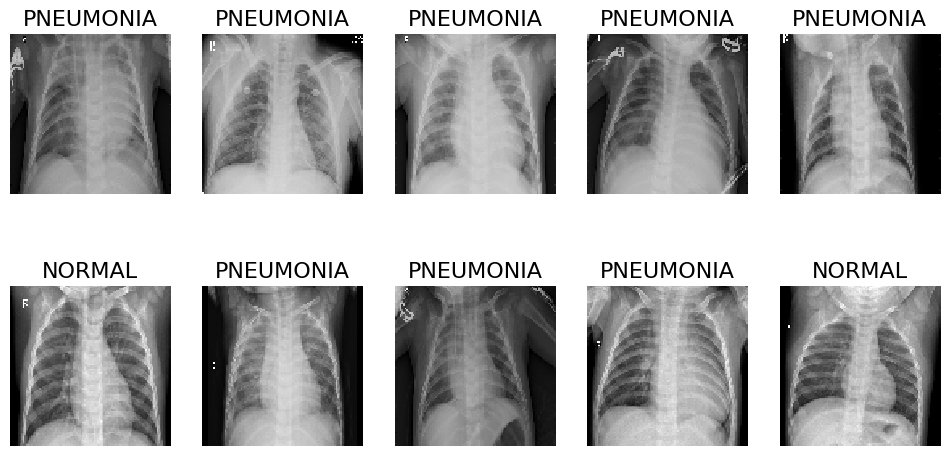

In [42]:
def plots_from_filepaths(filepaths, figsize=(12,6), rows=2, interp=False, titles=None):
    if not filepaths:
        print("La lista de rutas de archivo está vacía.")
        return

    # Asegúrate de no intentar mostrar más imágenes de las que tienes
    assert rows <= len(filepaths), "El número de filas es mayor que el número de imágenes a mostrar"

    ims = []
    for filepath in filepaths:
        img = image.load_img(filepath, target_size=(100, 100)) # Cambia el tamaño según sea necesario
        img = image.img_to_array(img)
        ims.append(img)

    ims = np.array(ims).astype(np.uint8)
    if ims.shape[-1] != 3:
        ims = ims.transpose((0,2,3,1))

    f = plt.figure(figsize=figsize)
    cols = int(np.ceil(len(ims) / rows))  # Aquí se calcula el número de columnas
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)  # Aquí se agrega cada subplot
        sp.axis('Off')
        if titles is not None and i < len(titles):
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
    plt.show()  # Asegúrate de llamar a plt.show() para visualizar el gráfico


# Ejemplo de uso:
# Suponiendo que quieres mostrar las primeras 10 imágenes del conjunto de entrenamiento
sample_filepaths = train_df['Filepath'].iloc[:10].tolist()
plots_from_filepaths(sample_filepaths, titles=train_df['Class'].iloc[:10].tolist())


In [ ]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

### Configurar los generadores

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Ajusta las rutas según la estructura de tu proyecto
train_path = 'data/train'
valid_path = 'data/val'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# Configurando los generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza las imágenes
    rotation_range=20,  # Rango de rotación aleatoria
    width_shift_range=0.1,  # Rango de cambio de ancho aleatorio
    height_shift_range=0.1,  # Rango de cambio de altura aleatorio
    zoom_range=0.1,  # Rango de zoom aleatorio
    horizontal_flip=True,  # Permite volteo horizontal
    fill_mode='nearest'  # Modo de llenado para cuando se aplican transformaciones
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Solo necesitamos reescalar para validación

# Configura el generador de entrenamiento
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,  # Ya se especifican las rutas completas en df_train
    x_col='Filepath',
    y_col='Class',
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    class_mode='binary'  # o 'categorical' si tienes más de dos clases
)

# Configura el generador de validación
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=None,  # Ya se especifican las rutas completas en df_val
    x_col='Filepath',
    y_col='Class',
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    class_mode='binary'  # o 'categorical' si tienes más de dos clases
)



Found 4860 validated image filenames belonging to 2 classes.
Found 996 validated image filenames belonging to 2 classes.


In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configura el generador de datos con la función de preprocesamiento de MobileNet
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

# Configuración de los generadores para los conjuntos de entrenamiento, validación y pruebas
# Asegúrate de ajustar las rutas a tus directorios y las variables de configuración según tus necesidades
train_batches = datagen.flow_from_directory('data/train',
                                            target_size=(224,224),
                                            batch_size=10)

valid_batches = datagen.flow_from_directory('data/val',
                                            target_size=(224,224),
                                            batch_size=10)

test_batches = datagen.flow_from_directory('data/val',  # Cambia esta ruta si tienes un directorio específico para pruebas
                                           target_size=(224,224),
                                           batch_size=1,
                                           shuffle=False)



Found 4860 images belonging to 2 classes.
Found 996 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


### Implementar y transformar el modelo de MobileNet

In [45]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.MobileNetV2()

In [46]:
mobile.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [47]:
type(mobile.layers)

list

In [48]:
# How many layers does MobileNet have?
len(mobile.layers)

156

In [49]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten

# create a copy of a mobilenet model
mobile = MobileNetV2()

# Calculate the index to freeze layers
num_layers = len(mobile.layers)
freeze_index = int(0.8 * num_layers)

# Freeze layers up to freeze_index
for layer in mobile.layers[:freeze_index]:
    layer.trainable = False

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-2].output

# Add dropout
x = Dropout(0.25)(x)

# Add dense layers
predictions = Dense(2, activation='softmax')(x)

# Define model
model = Model(inputs=mobile.input, outputs=predictions)

In [50]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 1,528,962 (5.83 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [51]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Entrenamiento del Modelo

In [52]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [53]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [54]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [55]:
class_weights = {
    0: 1.0,  # NORMAL
    1: 1.0,  # PNEUMONIA
}

# Supongamos que después de un análisis encuentras que aumentar la sensibilidad hacia la clase NORMAL es deseado
# Ajusta estos valores basado en tu análisis de la distribución de las clases
num_normal_samples = len(df_data[df_data['Class'] == 'NORMAL'])
num_pneumonia_samples = len(df_data[df_data['Class'] == 'PNEUMONIA'])

# Calcular el peso total de las muestras
total_samples = num_normal_samples + num_pneumonia_samples

# Calcular la proporción inversa de las clases para usar como peso
weight_for_normal = (1 / num_normal_samples) * (total_samples) / 2.0
weight_for_pneumonia = (1 / num_pneumonia_samples) * (total_samples) / 2.0

class_weights = {
    0: weight_for_normal,  # NORMAL
    1: weight_for_pneumonia,  # PNEUMONIA
}


In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Cambiando la extensión del archivo a .keras para indicar el formato SavedModel
filepath = "model_complete.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max', save_weights_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Asegurando que los pasos sean enteros
train_steps = int(train_steps)
val_steps = int(val_steps)

# Entrenamiento del modelo
history = model.fit(train_batches, steps_per_epoch=train_steps,
                    class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                    callbacks=callbacks_list)

# Guarda el modelo completo usando la extensión .keras
model.save('model_final.h5')



Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_accuracy: 0.8726 - loss: 0.4616 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 1: val_categorical_accuracy improved from -inf to 0.82329, saving model to model_complete.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 82s 133ms/step - categorical_accuracy: 0.8727 - loss: 0.4611 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_categorical_accuracy: 0.8233 - val_loss: 7.3945 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0100
Epoch 2/30

Epoch 2: val_categorical_accuracy did not improve from 0.82329
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - top_2_accuracy: 0.0000e+00 - top_3_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_top_2_accuracy: 0.0000e+00 - val_top_3_accuracy: 0.0000e+00 - learning_rate: 0.0100
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_accuracy: 0.9378 - loss: 0.1863 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 3: val_categorical_accuracy did not improve from 0.82329

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
486/486 ━━━━━━━━━━━━━━━━━━━━ 66s 118ms/step - categorical_accuracy: 0.9378 - loss: 0.1864 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_categorical_accuracy: 0.7771 - val_loss: 0.5865 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0100
Epoch 4/30

Epoch 4: val_categorical_accuracy did not improve from 0.82329
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - top_2_accuracy: 0.0000e+00 - top_3_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_top_2_accuracy: 0.0000e+00 - val_top_3_accuracy: 0.0000e+00 - learning_rate: 0.0050
Epoch 5/30
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorica

In [57]:
!ls

 base_dir	  carpeta_salida.zip  'kaggle (1).json'   model_complete.keras	 sample_data
 carpeta_salida   data		       kaggle.json	  model_final.h5


In [58]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Evaluar el modelo utilizando el conjunto de valores de validación

In [59]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

In [60]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches,
                        steps=len(df_val))           ###########Antes decia evaluate.generator pero ya está desfasado

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

996/996 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - categorical_accuracy: 0.9438 - loss: 0.2295 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
val_loss: 0.12141073495149612
val_cat_acc: 0.9678714871406555
val_top_2_acc: 1.0
val_top_3_acc: 1.0


In [61]:
# Here the best epoch will be used.

model.load_weights('model_final.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches,
                        steps=len(df_val))  ###############Decía evaluate_generator pero el código está desfasado

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

996/996 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - categorical_accuracy: 0.9438 - loss: 0.2295 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
val_loss: 0.12141073495149612
val_cat_acc: 0.9678714871406555
val_top_2_acc: 1.0
val_top_3_acc: 1.0


### Trazar las curvas de entrenamiento

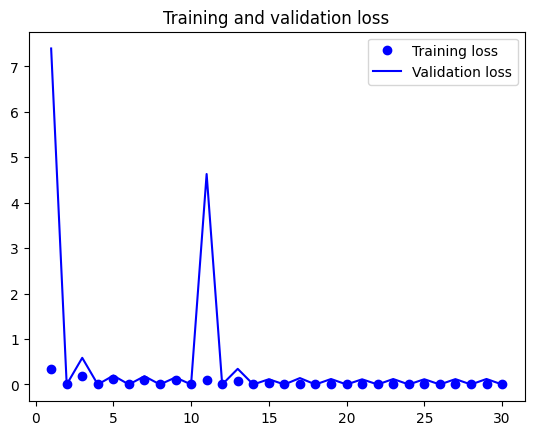

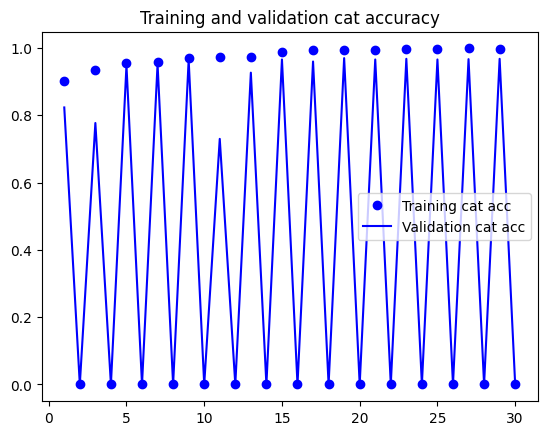

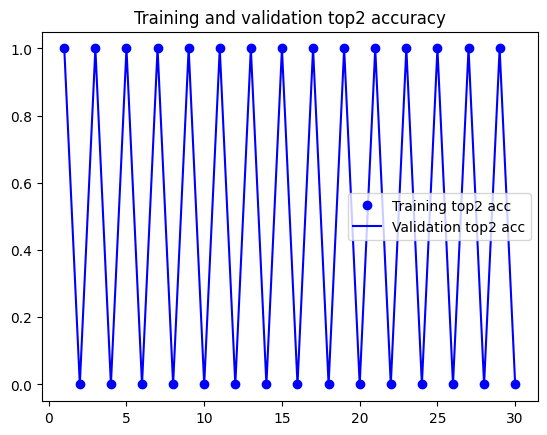

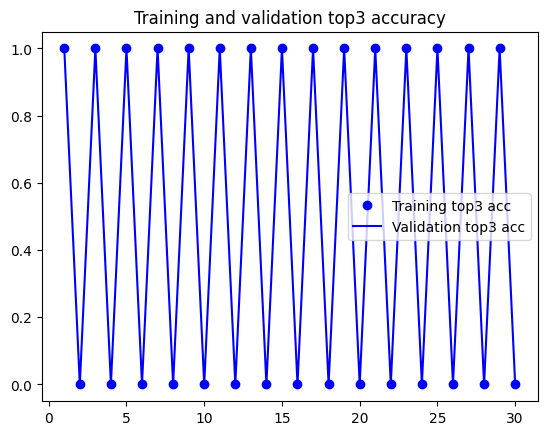

In [62]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Creando la matriz de confusión

In [63]:
# Get the labels of the test images.
# Note that cats and dogs are in seperate folders therefore
# the code below can get the labels depending on the folder the image is in.

test_labels = test_batches.classes

In [64]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [65]:
# Print the label associated with each class
test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [66]:
# make a prediction
predictions = model.predict(test_batches, steps=len(df_val), verbose=1) ##Se cambió el código anterior que era 'predict.generator'

996/996 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step


In [67]:
predictions.shape

(996, 2)

In [68]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [69]:
test_labels.shape

(996,)

In [70]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [71]:
test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[250  19]
 [ 13 714]]


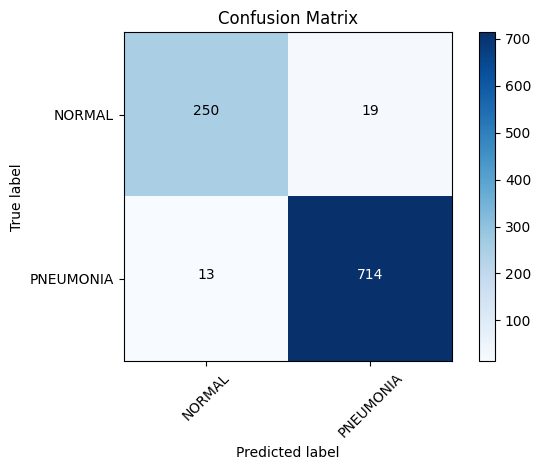

In [72]:
# Define las etiquetas de los índices de la clase para tu dataset actual
cm_plot_labels = ['NORMAL', 'PNEUMONIA']

# Suponiendo que 'plot_confusion_matrix' es una función que ya está definida en tu entorno,
# la cual dibuja la matriz de confusión
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


In [ ]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

In [73]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [74]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      NORMAL       0.95      0.93      0.94       269
   PNEUMONIA       0.97      0.98      0.98       727

    accuracy                           0.97       996
   macro avg       0.96      0.96      0.96       996
weighted avg       0.97      0.97      0.97       996



Recall = Given a class, will the classifier be able to detect it?

Precision = Given a class prediction from a classifier, how likely is it to be correct?

F1 Score = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

### Install Tensorflow.js

In [75]:
!pip install tensorflowjs

In [76]:
!rm -rf carpeta_salida  # Elimina la carpeta si existe
# Crear carpeta donde se colocarán los archivos resultantes
!mkdir carpeta_salida

# Realizar la conversión al formato TensorFlow.js y guardar en la carpeta de salida
!tensorflowjs_converter --input_format=keras model_final.h5 carpeta_salida


2024-04-02 16:02:04.996035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 962, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 948, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 618, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/loca

In [77]:
#Confirmar que en la carpeta de salida se hayan generado los archivos. Deben aparecer archivos "bin" y "json"
!ls carpeta_salida

In [78]:
!zip -r carpeta_salida.zip carpeta_salida

from google.colab import files
files.download('carpeta_salida.zip')

updating: carpeta_salida/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Resources

These are some resources that I used:

1. Excellent tutorial series by deeplizard on how to use Mobilenet with Tensorflow.js<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

2. Tutorial by Minsuk Heo on Accuracy, Precision and F1 Score<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

3. Tutorial by Data School on how to evaluate a classifier<br>
https://www.youtube.com/watch?v=85dtiMz9tSo

3. Tensorflow.js gallery of projects<br>
https://github.com/tensorflow/tfjs/blob/master/GALLERY.md

